In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('social_data.xlsx')
print(data.shape)
data.head(20)

(3479, 7)


,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video
5,2023-03-31 19:42:11.331,CSGO,TWITTER,N/A,0,0,Photo
6,2023-03-31 19:40:57.383,CSGO,TWITTER,Community Engagement,1882,83,Photo
7,2023-03-31 19:23:57.349,CSGO,TWITTER,Community Engagement,17892,3076,Video
8,2023-03-31 19:15:14.431,CSGO,TWITTER,N/A,0,0,Video
9,2023-03-31 18:55:51.855,CSGO,TWITTER,Community Engagement,13874,1447,Video


### Checking for nan values

In [3]:
data.isna().sum()

Published Date       0
Account              0
Account Type         0
Campaign Name        0
Total Impressions    0
Total Engagements    0
Media Type           0
dtype: int64

### Data Cleaning
- Saw Account had 'General' and 'General ', combined them together since 'General' had LINKEDIN_COMPANY tag.

In [4]:
data['Account'].value_counts()

General             2271
DOTA2                803
CSGO                 270
Valorant              60
Content Creators      53
General               22
Name: Account, dtype: int64

In [5]:
print(data[data['Account']=='General ']['Account Type'].value_counts())
print(data[data['Account']=='General']['Account Type'].value_counts())
data['Account'] = data['Account'].replace('General ', 'General')

TWITTER            886
INSTAGRAM          588
FBPAGE             585
TIKTOK_BUSINESS    113
YOUTUBE             99
Name: Account Type, dtype: int64
LINKEDIN_COMPANY    22
Name: Account Type, dtype: int64


### Engagement Rate
$$Engagement\ Rate = \frac{Total\ Engagements}{Total\ Impressions} * 100$$

In [6]:
data['Engagement Rate'] = data.apply(lambda r:r['Total Engagements']/(r['Total Impressions'])*100 if r['Total Impressions'] != 0 else 0, axis=1)
data

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text,0.000000
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text,0.000000
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text,0.000000
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text,0.000000
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video,12.766628
...,...,...,...,...,...,...,...,...
3474,2023-01-03 10:35:12.652,CSGO,TWITTER,N/A,0,0,Link,0.000000
3475,2023-01-03 10:34:55.487,CSGO,TWITTER,N/A,0,0,Link,0.000000
3476,2023-01-03 10:34:38.631,CSGO,TWITTER,N/A,0,0,Link,0.000000
3477,2023-01-03 10:34:03.438,CSGO,TWITTER,N/A,2116,42,Text,1.984877


### Checking for Outliers

|Index|Impression|Engagement|
|---|---|---|
|837|1|940|
|3457|300|3776|
|3216|5|44|
|1586|1|1|

In [7]:
data.iloc[[837,3457,3216,1586],:]

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate
837,2023-03-10 12:37:06,General,FBPAGE,N/A,1,940,Photo,94000.000000
3457,2023-01-05 11:55:44,General,FBPAGE,N/A,300,3776,Photo,1258.666667
3216,2023-01-19 06:02:34,General,FBPAGE,N/A,5,44,Photo,880.000000
1586,2023-02-23 06:18:27,General,FBPAGE,N/A,1,1,Photo,100.000000


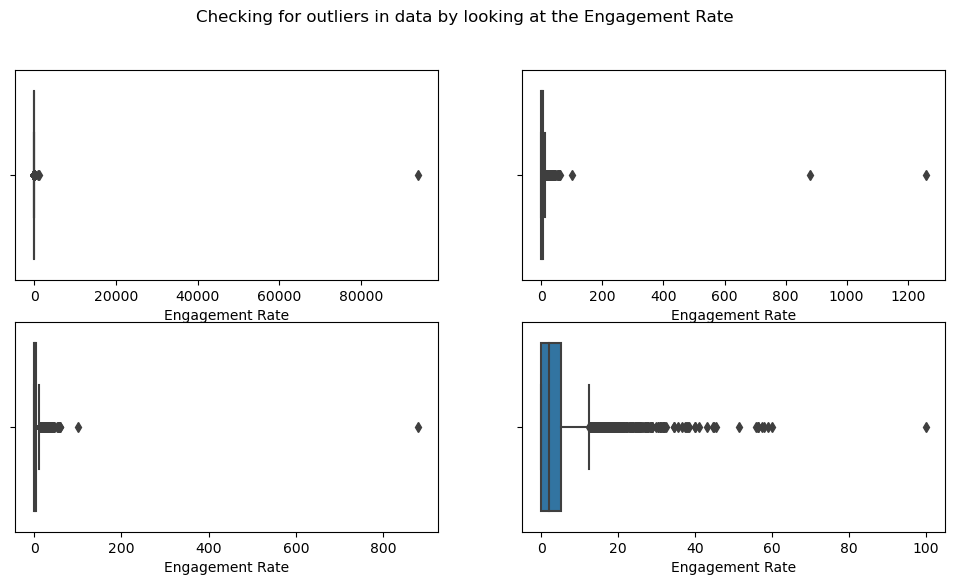

In [8]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.suptitle('Checking for outliers in data by looking at the Engagement Rate')
sns.boxplot(x=data['Engagement Rate'], ax=ax[0][0])
data = data.drop(837).reset_index(drop=True)
sns.boxplot(x=data['Engagement Rate'], ax=ax[0][1])
data = data.drop(3456).reset_index(drop=True)
sns.boxplot(x=data['Engagement Rate'], ax=ax[1][0])
data = data.drop(3215).reset_index(drop=True)
sns.boxplot(x=data['Engagement Rate'], ax=ax[1][1])
data = data.drop(1585).reset_index(drop=True)
plt.savefig("figs/0 outliers.png")
plt.show()

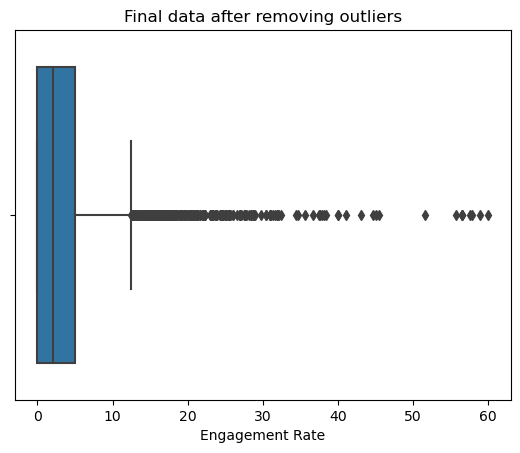

In [9]:
# final
plt.title('Final data after removing outliers')
sns.boxplot(x=data['Engagement Rate'])
plt.savefig("figs/0 final_eng_rate.png")
plt.show()

In [10]:
data['Engagement Rate'].value_counts()

0.000000    966
2.150538      5
5.000000      4
3.225806      4
1.388889      4
           ... 
1.514201      1
7.355003      1
4.108527      1
1.664932      1
1.984877      1
Name: Engagement Rate, Length: 2416, dtype: int64

##### 1. What is the typical engagment rate we can expect? What's the likelihood that we can achieve a 15% engagement rate?

In [11]:
data.describe()

,Total Impressions,Total Engagements,Engagement Rate
count,3475.000000,3475.000000,3475.000000
mean,10984.995396,947.111079,4.175152
std,29591.818356,3470.221546,6.538214
min,0.000000,0.000000,0.000000
25%,169.000000,0.000000,0.000000
50%,1888.000000,38.000000,2.038835
75%,12469.000000,276.000000,5.000000
max,753227.000000,95062.000000,60.000000


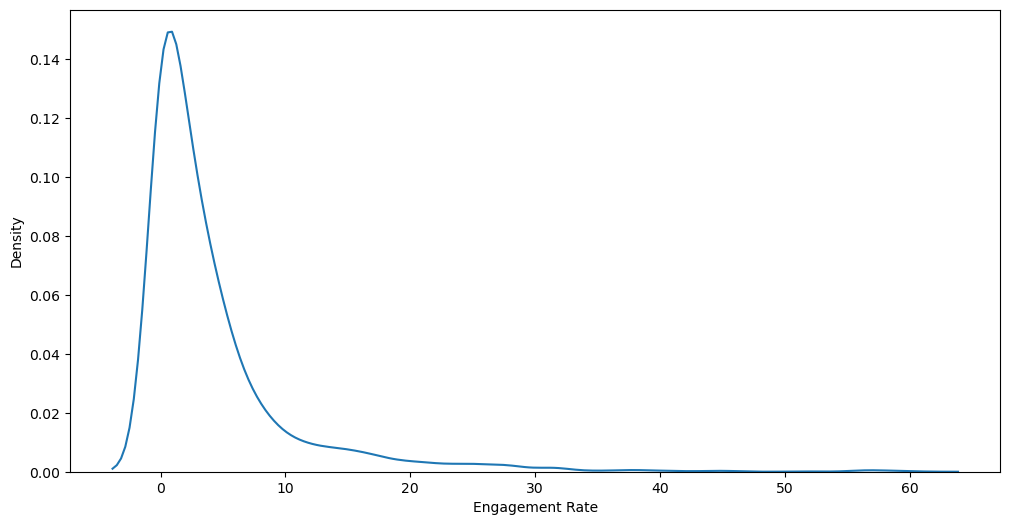

In [12]:
plt.figure(figsize=(12,6))
sns.kdeplot(x = data['Engagement Rate'])
plt.savefig("figs/1 data_dist.png")
plt.show()

##### 2. Does day of the week and time of posting affect engagement rates?

In [13]:
weekdays = {1: "Monday",
            2: "Tuesday",
            3: "Wednesday",
            4: "Thursday",
            5: "Friday",
            6: "Saturday",
            7: "Sunday"}
data['Day Of Week'] = data.apply(lambda r:weekdays[r['Published Date'].isoweekday()], axis=1)
data

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate,Day Of Week
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video,12.766628,Friday
...,...,...,...,...,...,...,...,...,...
3470,2023-01-03 10:35:12.652,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday
3471,2023-01-03 10:34:55.487,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday
3472,2023-01-03 10:34:38.631,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday
3473,2023-01-03 10:34:03.438,CSGO,TWITTER,N/A,2116,42,Text,1.984877,Tuesday


,Total Impressions,Total Engagements,Engagement Rate,Count
Day Of Week,,,,
Tuesday,12828.923351,1303.898396,5.055946,561
Thursday,12122.899004,1082.644381,4.780459,703
Sunday,9923.795213,1051.808511,4.297761,376
Friday,10581.487977,907.575672,4.195042,707
Monday,10581.320513,710.594017,3.590710,234
Wednesday,9976.441739,780.027826,3.322831,575
Saturday,9493.708464,459.855799,3.068647,319


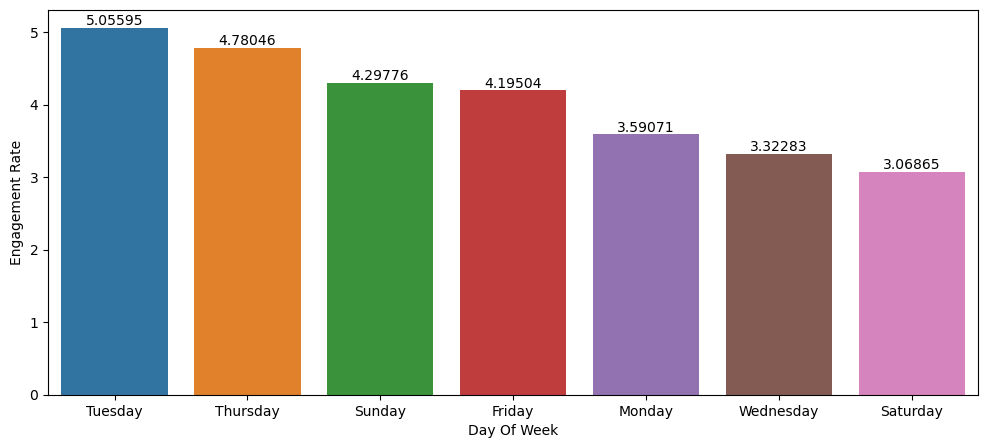

In [14]:
day_data = data.groupby('Day Of Week').mean(numeric_only=True).sort_values(by = 'Engagement Rate', ascending=False)
day_data['Count'] = data['Day Of Week'].value_counts()
display(day_data)
fig2, ax2 = plt.subplots(figsize=(12,5))
ax2 = sns.barplot(x=day_data.index, y=day_data['Engagement Rate'])
for i in ax2.containers:
    ax2.bar_label(i,)
plt.savefig("figs/2 day of week.png")
plt.show()

In [15]:
data['Time Of Day'] = pd.cut(
    pd.to_datetime(data['Published Date']).dt.hour,
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    right=False,
    include_lowest=True
)

data

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate,Day Of Week,Time Of Day
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video,12.766628,Friday,Evening
...,...,...,...,...,...,...,...,...,...,...
3470,2023-01-03 10:35:12.652,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday,Morning
3471,2023-01-03 10:34:55.487,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday,Morning
3472,2023-01-03 10:34:38.631,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday,Morning
3473,2023-01-03 10:34:03.438,CSGO,TWITTER,N/A,2116,42,Text,1.984877,Tuesday,Morning


,Total Impressions,Total Engagements,Engagement Rate,Count
Time Of Day,,,,
Night,10147.729167,2071.604167,7.876963,48
Morning,12467.673352,1033.527221,4.363287,1396
Afternoon,10284.404525,884.007174,4.017833,1812
Evening,7513.949772,671.913242,3.466193,219


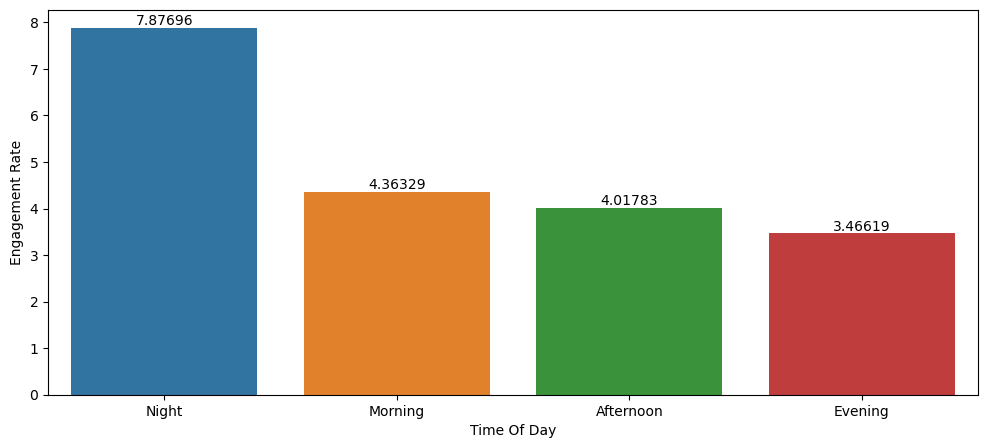

In [16]:
time_data = data.groupby('Time Of Day').mean(numeric_only=True).sort_values(by = 'Engagement Rate', ascending=False)
time_data['Count'] = data['Time Of Day'].value_counts()
display(time_data)
fig3, ax3 = plt.subplots(figsize=(12,5))
ax3 = sns.barplot(x=time_data.index, y=time_data['Engagement Rate'])
for i in ax3.containers:
    ax3.bar_label(i,)
plt.savefig("figs/2 time of day.png")
plt.show()

##### 3. How are our game titles doing in terms of social performance? Is there a specific game we should focus more on or less?

In [17]:
data['Account'].value_counts()

General             2289
DOTA2                803
CSGO                 270
Valorant              60
Content Creators      53
Name: Account, dtype: int64

,Total Impressions,Total Engagements,Engagement Rate,Count
Account,,,,
General,14823.700306,1342.318480,4.299421,2289
DOTA2,2315.474471,154.408468,4.298295,803
Content Creators,852.566038,26.169811,4.075632,53
CSGO,8570.066667,341.985185,3.030547,270
Valorant,382.983333,15.516667,3.024861,60


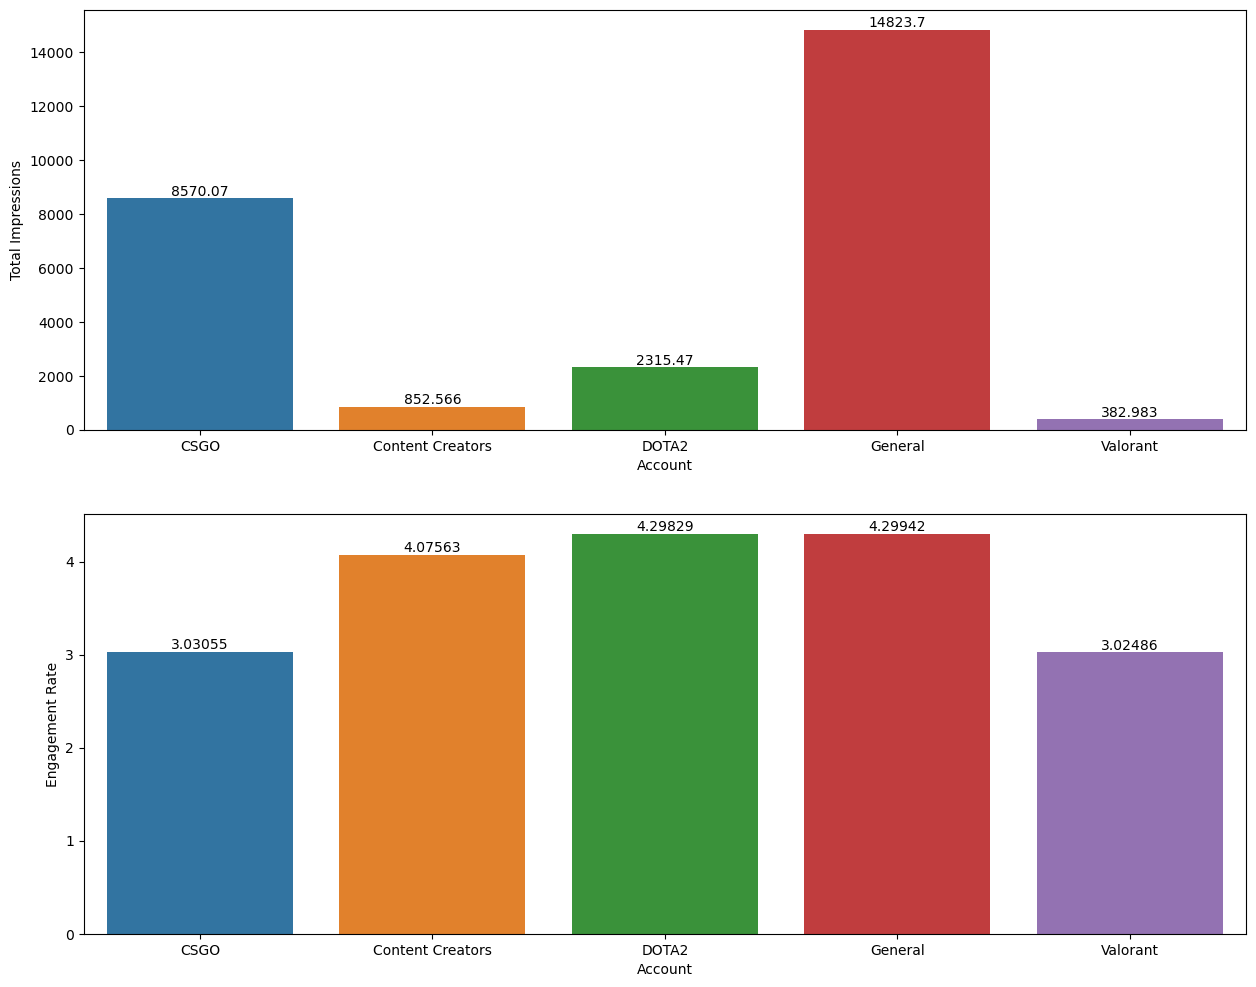

In [18]:
game_data = data.groupby('Account').mean(numeric_only=True)
game_data['Count'] = data['Account'].value_counts()
display(game_data.sort_values(by='Engagement Rate', ascending=False))

fig4, ax4 = plt.subplots(2, figsize=(15,12))
ax_x = sns.barplot(x=game_data.index, y=game_data['Total Impressions'], ax=ax4[0])
for i in ax_x.containers:
    ax_x.bar_label(i,)
ax_y = sns.barplot(x=game_data.index, y=game_data['Engagement Rate'], ax=ax4[1])
for i in ax_y.containers:
    ax_y.bar_label(i,)
plt.savefig("figs/3 game type.png")
plt.show()

##### 4. Which media type performs the best?

In [19]:
data['Media Type'].value_counts()

Photo       1486
Video        967
Text         910
Link          94
Carousel       9
Mixed          5
Album          4
Name: Media Type, dtype: int64

,Total Impressions,Total Engagements,Engagement Rate,Count
Media Type,,,,
Mixed,36996.800000,2732.800000,10.770357,5
Album,5.000000,2.000000,10.000000,4
Video,10956.373320,888.780765,4.903493,967
Photo,16079.195828,1455.570659,4.877078,1486
Carousel,17854.333333,726.777778,3.784294,9
Text,3413.409890,270.672527,2.459318,910
Link,2473.031915,24.010638,1.635631,94


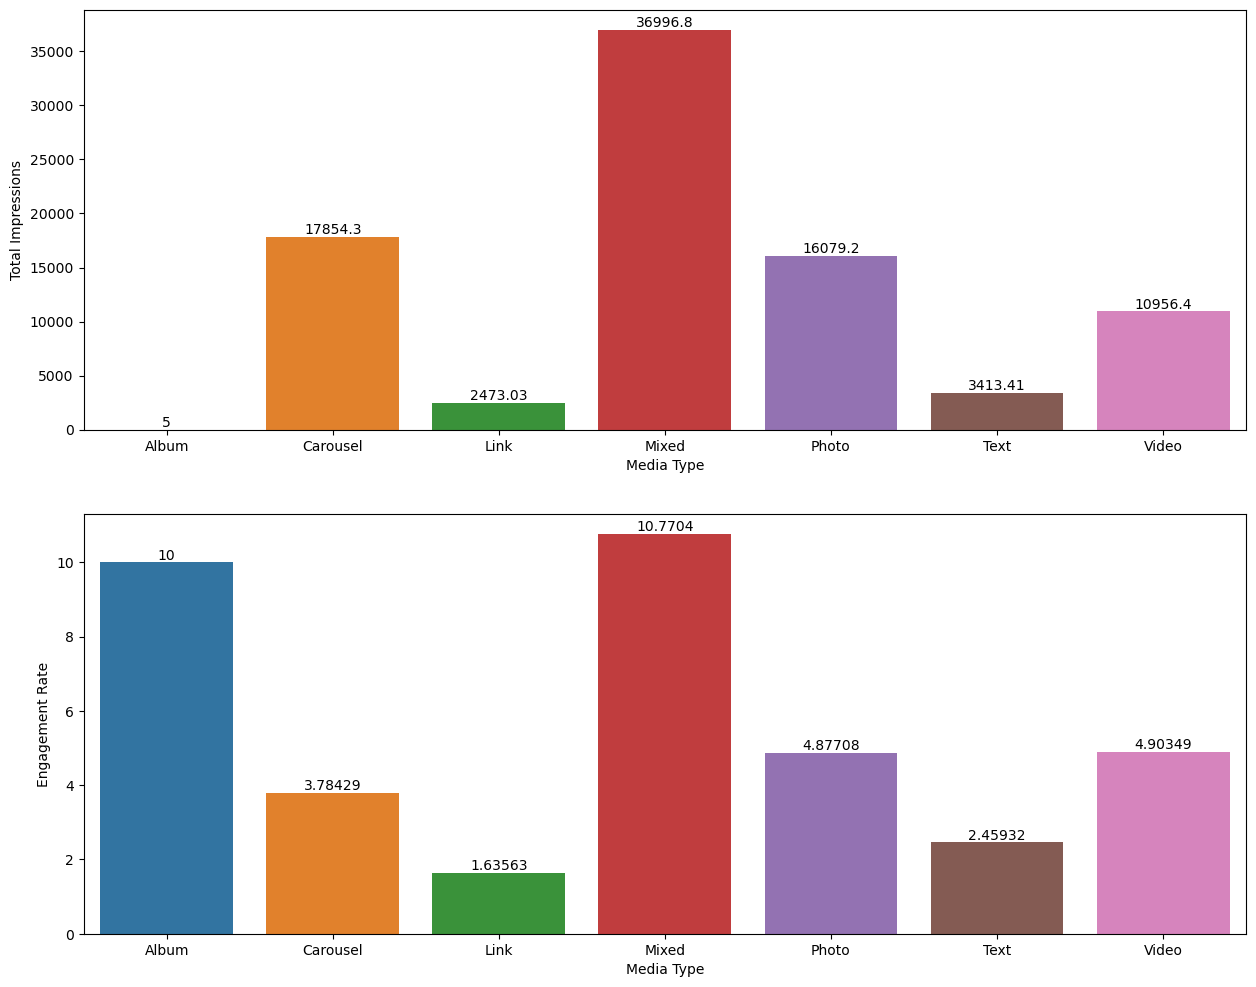

In [20]:
media_data = data.groupby('Media Type').mean(numeric_only=True)
media_data['Count'] = data['Media Type'].value_counts()
# thinking of dropping album as there are too few impressions to judge the engagement
# media_data = media_data.drop('Album')
display(media_data.sort_values(by='Engagement Rate', ascending=False))

fig5, ax5 = plt.subplots(2, figsize=(15,12))
ax_x = sns.barplot(x=media_data.index, y=media_data['Total Impressions'], ax=ax5[0])
for i in ax_x.containers:
    ax_x.bar_label(i,)
ax_y = sns.barplot(x=media_data.index, y=media_data['Engagement Rate'], ax=ax5[1])
for i in ax_y.containers:
    ax_y.bar_label(i,)
plt.savefig("figs/4 media type.png")
plt.show()

##### 5. What is our best performing campaign?

In [21]:
data['Campaign Name'].value_counts()

N/A                      1481
Community Engagement     1411
Evil Exhibited            420
Evergreen                 163
Name: Campaign Name, dtype: int64

,Total Impressions,Total Engagements,Engagement Rate,Count
Campaign Name,,,,
Community Engagement,16870.131821,1449.161588,5.634547,1411
Evergreen,8151.711656,264.582822,3.467474,163
N/A,4927.602296,687.381499,3.286123,1481
Evil Exhibited,13672.845238,441.202381,2.681813,420


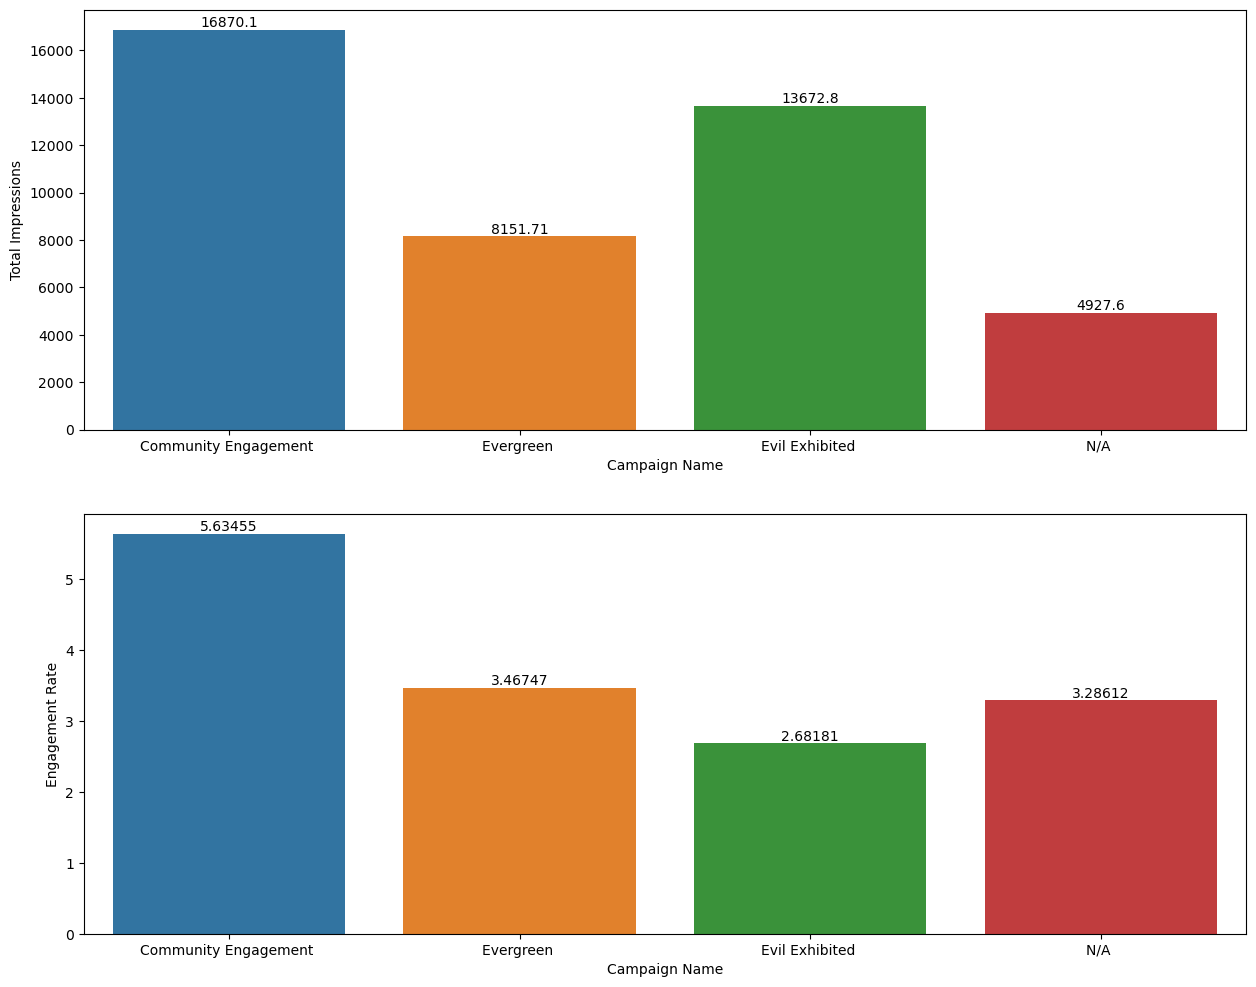

In [22]:
camp_data = data.groupby('Campaign Name').mean(numeric_only=True)
camp_data['Count'] = data['Campaign Name'].value_counts()
display(camp_data.sort_values(by='Engagement Rate', ascending=False))

fig6, ax6 = plt.subplots(2, figsize=(15,12))
ax_x = sns.barplot(x=camp_data.index, y=camp_data['Total Impressions'], ax=ax6[0])
for i in ax_x.containers:
    ax_x.bar_label(i,)
ax_y = sns.barplot(x=camp_data.index, y=camp_data['Engagement Rate'], ax=ax6[1])
for i in ax_y.containers:
    ax_y.bar_label(i,)
plt.savefig("figs/5 campaign type.png")
plt.show()

##### Suggestions

In [23]:
data['Account Type'].value_counts()

TWITTER             1951
INSTAGRAM            588
FBPAGE               581
YOUTUBE              220
TIKTOK_BUSINESS      113
LINKEDIN_COMPANY      22
Name: Account Type, dtype: int64

In [24]:
data[data['Account Type'] == 'TWITTER']['Account'].value_counts()

General    886
DOTA2      795
CSGO       270
Name: Account, dtype: int64

In [25]:
data[data['Account Type'] == 'TWITTER'].describe()

,Total Impressions,Total Engagements,Engagement Rate
count,1951.000000,1951.000000,1951.000000
mean,9995.179908,309.871348,3.248994
std,30932.154371,974.696962,3.713681
min,0.000000,0.000000,0.000000
25%,423.000000,9.000000,0.877716
50%,1649.000000,51.000000,2.248996
75%,10560.000000,223.500000,4.496582
max,452337.000000,12348.000000,60.000000


In [26]:
data[(data['Account Type'] == 'TWITTER')&(data['Account']=='DOTA2')].describe()

,Total Impressions,Total Engagements,Engagement Rate
count,795.000000,795.000000,795.000000
mean,2252.592453,150.174843,4.310028
std,4075.260349,352.918074,3.934699
min,0.000000,0.000000,0.000000
25%,400.000000,7.000000,1.537387
50%,1013.000000,34.000000,3.540813
75%,2423.000000,132.000000,5.921992
max,39432.000000,4465.000000,25.389466


In [27]:
data[(data['Account Type'] == 'TWITTER')&(data['Account']=='CSGO')].describe()

,Total Impressions,Total Engagements,Engagement Rate
count,270.000000,270.000000,270.000000
mean,8570.066667,341.985185,3.030547
std,36832.498876,1162.159415,3.868445
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1501.500000,23.500000,1.759788
75%,3276.000000,113.000000,3.452529
max,445130.000000,10909.000000,17.192041


In [28]:
data[data['Account Type'] == 'YOUTUBE']['Account'].value_counts()

General             99
Valorant            60
Content Creators    53
DOTA2                8
Name: Account, dtype: int64

In [29]:
data[data['Account Type'] == 'YOUTUBE'].describe()

,Total Impressions,Total Engagements,Engagement Rate
count,220.000000,220.000000,220.000000
mean,1083.650000,46.945455,3.048881
std,4570.975006,299.680190,4.102267
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,306.000000,9.500000,2.569124
75%,971.750000,35.000000,4.335485
max,64879.000000,4388.000000,37.931034


In [30]:
data[(data['Account Type']=='YOUTUBE')&(data['Account']=='Content Creators')].describe()

,Total Impressions,Total Engagements,Engagement Rate
count,53.000000,53.000000,53.000000
mean,852.566038,26.169811,4.075632
std,1245.170663,33.082494,6.827298
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,150.000000,11.000000,2.478134
75%,1676.000000,45.000000,4.460967
max,5685.000000,130.000000,37.931034


In [31]:
data[(data['Account Type']=='YOUTUBE')&(data['Account']=='Valorant')].describe()

,Total Impressions,Total Engagements,Engagement Rate
count,60.000000,60.000000,60.000000
mean,382.983333,15.516667,3.024861
std,1598.664522,60.028381,3.581828
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,27.000000,1.500000,2.092041
75%,300.750000,13.250000,5.152596
max,12320.000000,463.000000,14.285714


In [32]:
data[(data['Account Type']=='YOUTUBE')&(data['Account']=='DOTA2')].describe()

,Total Impressions,Total Engagements,Engagement Rate
count,8.000000,8.000000,8.000000
mean,8564.375000,575.125000,3.132272
std,22766.137579,1541.164165,3.429655
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,345.500000,18.500000,2.651696
75%,1162.250000,76.500000,5.712579
max,64879.000000,4388.000000,7.629108


In [33]:
data[(data['Account Type']=='YOUTUBE')&(data['Account']=='CSGO')].describe()

,Total Impressions,Total Engagements,Engagement Rate
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


##### Calculating the likelihood for a non-normal distribution

In [34]:
def compute_likelihood(data, threshold):
    ecdf = stats.cumfreq(data, numbins=1000000)
    x = ecdf.lowerlimit + np.linspace(0, ecdf.binsize*ecdf.cumcount.size, ecdf.cumcount.size)
    idx = np.searchsorted(x, threshold, side='right')
    likelihood = 1 - ecdf.cumcount[idx]/len(data)
    return likelihood

# suppose your engagement rate data looks like this:
engagement_data = np.array(data.loc[:,'Engagement Rate'])  # replace [...] with your real data

# you want to find the likelihood of achieving at least 15% engagement rate
threshold = 15

likelihood = compute_likelihood(engagement_data, threshold)
print(f'The likelihood of achieving at least a {threshold}% engagement rate is {likelihood*100}%')

The likelihood of achieving at least a 15% engagement rate is 6.388489208633096%


##### Extra

In [35]:
data

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate,Day Of Week,Time Of Day
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video,12.766628,Friday,Evening
...,...,...,...,...,...,...,...,...,...,...
3470,2023-01-03 10:35:12.652,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday,Morning
3471,2023-01-03 10:34:55.487,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday,Morning
3472,2023-01-03 10:34:38.631,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday,Morning
3473,2023-01-03 10:34:03.438,CSGO,TWITTER,N/A,2116,42,Text,1.984877,Tuesday,Morning


In [36]:
one_hot_data = pd.get_dummies(data, columns=['Day Of Week','Time Of Day','Account','Account Type','Campaign Name','Media Type'])
#one_hot_data['Engagement Rate'] = one_hot_data.apply(lambda r:r['Total Engagements']/(r['Total Impressions'])*100 if r['Total Impressions'] != 0 else 0, axis=1)
one_hot_data = one_hot_data.drop(columns=['Published Date','Total Impressions','Total Engagements'])
display(one_hot_data['Engagement Rate'].value_counts())
#one_hot_data = one_hot_data[one_hot_data['Engagement Rate']!=0.0].reset_index(drop=True)
one_hot_data

0.000000    966
2.150538      5
5.000000      4
3.225806      4
1.388889      4
           ... 
1.514201      1
7.355003      1
4.108527      1
1.664932      1
1.984877      1
Name: Engagement Rate, Length: 2416, dtype: int64

,Engagement Rate,Day Of Week_Friday,Day Of Week_Monday,Day Of Week_Saturday,Day Of Week_Sunday,Day Of Week_Thursday,Day Of Week_Tuesday,Day Of Week_Wednesday,Time Of Day_Night,Time Of Day_Morning,...,Campaign Name_Evergreen,Campaign Name_Evil Exhibited,Campaign Name_N/A,Media Type_Album,Media Type_Carousel,Media Type_Link,Media Type_Mixed,Media Type_Photo,Media Type_Text,Media Type_Video
0,0.000000,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0.000000,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0.000000,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.000000,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,12.766628,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,0.000000,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0
3471,0.000000,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0
3472,0.000000,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,0,0
3473,1.984877,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0


In [37]:
one_hot_data.columns

Index(['Engagement Rate', 'Day Of Week_Friday', 'Day Of Week_Monday',
       'Day Of Week_Saturday', 'Day Of Week_Sunday', 'Day Of Week_Thursday',
       'Day Of Week_Tuesday', 'Day Of Week_Wednesday', 'Time Of Day_Night',
       'Time Of Day_Morning', 'Time Of Day_Afternoon', 'Time Of Day_Evening',
       'Account_CSGO', 'Account_Content Creators', 'Account_DOTA2',
       'Account_General', 'Account_Valorant', 'Account Type_FBPAGE',
       'Account Type_INSTAGRAM', 'Account Type_LINKEDIN_COMPANY',
       'Account Type_TIKTOK_BUSINESS', 'Account Type_TWITTER',
       'Account Type_YOUTUBE', 'Campaign Name_Community Engagement ',
       'Campaign Name_Evergreen ', 'Campaign Name_Evil Exhibited ',
       'Campaign Name_N/A ', 'Media Type_Album', 'Media Type_Carousel',
       'Media Type_Link', 'Media Type_Mixed', 'Media Type_Photo',
       'Media Type_Text', 'Media Type_Video'],
      dtype='object')

In [38]:
X = one_hot_data.iloc[:,1:]
y = one_hot_data.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)
pred = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  5.424781


In [39]:
#X_sampled = X_train.sample(100, random_state=10)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)

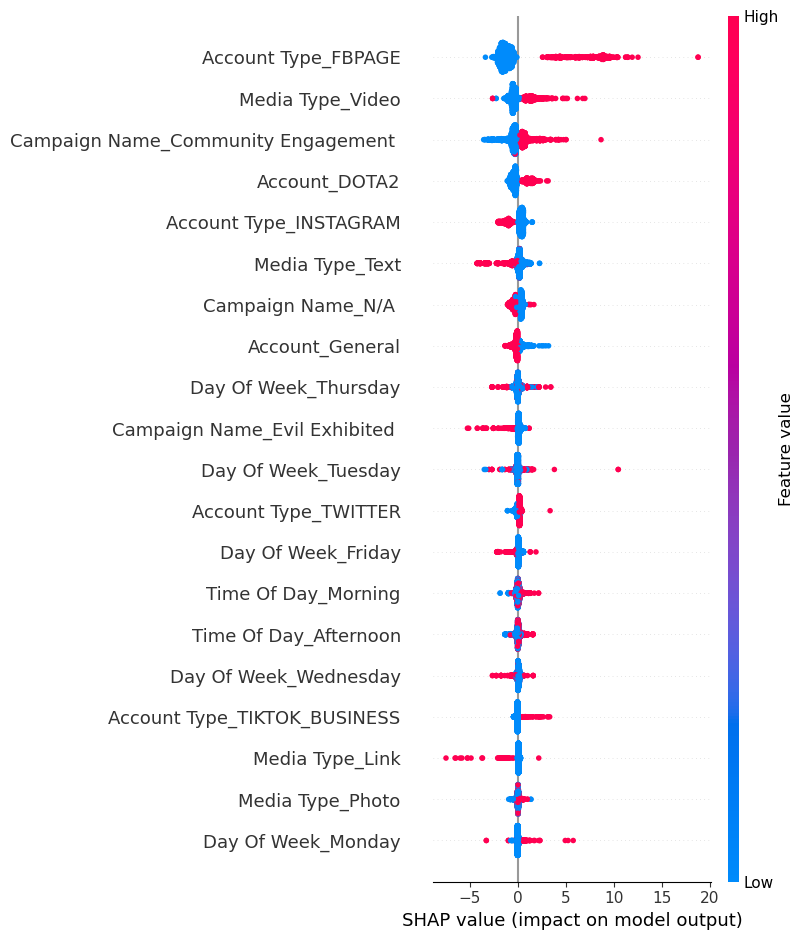

In [40]:
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig('figs/e_shap_feature_imp_plot.png')

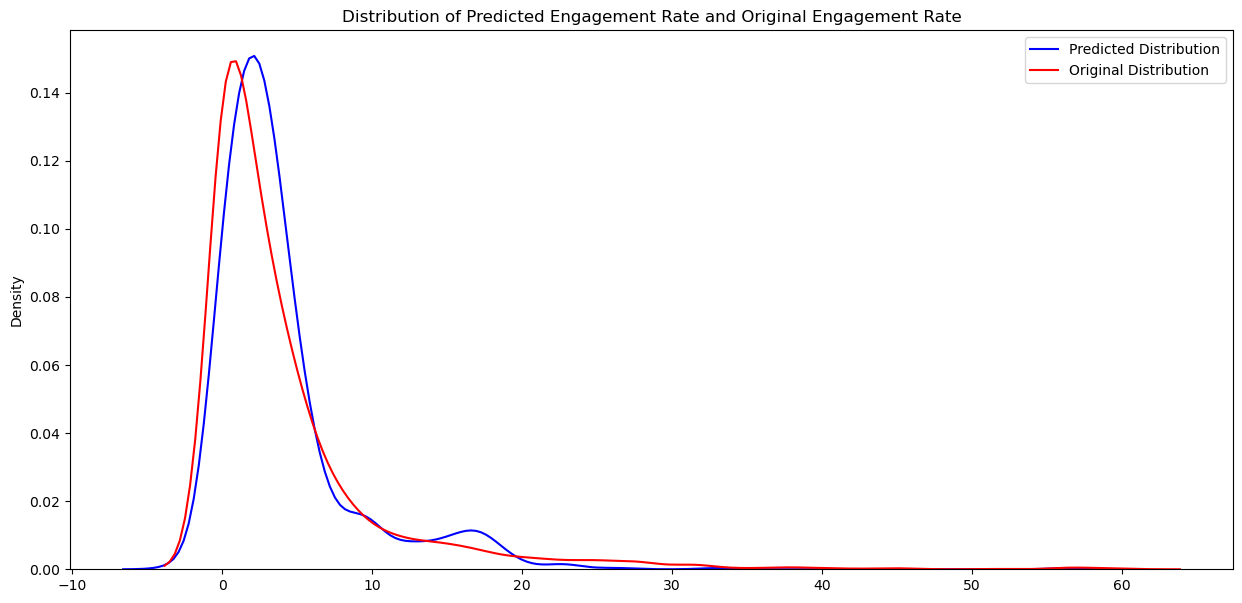

In [41]:
pred = np.array(pred)
original = np.array(one_hot_data.loc[:,'Engagement Rate'])

def average_gap(l1,l2):
    resu=0
    for i in range(len(l1)):
        resu += np.abs(l1[i]-l2[i])
    resu = resu/len(l1)
    return(resu)

plt.figure(figsize=(15,7))
sns.kdeplot(pred, color="blue", label="Predicted Distribution")
sns.kdeplot(original, color="red", label="Original Distribution")
plt.title("Distribution of Predicted Engagement Rate and Original Engagement Rate")
plt.legend()
plt.savefig('figs/e_pred_og_dist.png')
plt.show()

In [42]:
data

,Published Date,Account,Account Type,Campaign Name,Total Impressions,Total Engagements,Media Type,Engagement Rate,Day Of Week,Time Of Day
0,2023-03-31 19:55:43.192,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
1,2023-03-31 19:49:35.243,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
2,2023-03-31 19:49:33.535,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
3,2023-03-31 19:49:31.583,CSGO,TWITTER,N/A,0,0,Text,0.000000,Friday,Evening
4,2023-03-31 19:43:42.590,CSGO,TWITTER,Community Engagement,9517,1215,Video,12.766628,Friday,Evening
...,...,...,...,...,...,...,...,...,...,...
3470,2023-01-03 10:35:12.652,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday,Morning
3471,2023-01-03 10:34:55.487,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday,Morning
3472,2023-01-03 10:34:38.631,CSGO,TWITTER,N/A,0,0,Link,0.000000,Tuesday,Morning
3473,2023-01-03 10:34:03.438,CSGO,TWITTER,N/A,2116,42,Text,1.984877,Tuesday,Morning


<Axes: xlabel='Account Type_FBPAGE', ylabel='Engagement Rate'>

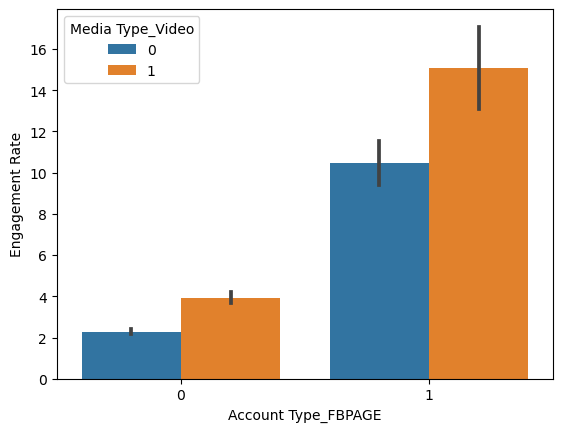

In [43]:
sns.barplot(y='Engagement Rate',x='Account Type_FBPAGE', hue='Media Type_Video', data=one_hot_data)

<Axes: xlabel='Account Type_INSTAGRAM', ylabel='Engagement Rate'>

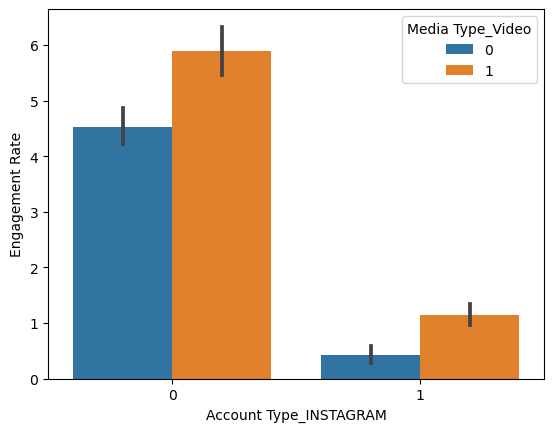

In [44]:
sns.barplot(y='Engagement Rate',x='Account Type_INSTAGRAM', hue='Media Type_Video', data=one_hot_data)

<Axes: xlabel='Media Type_Video', ylabel='Engagement Rate'>

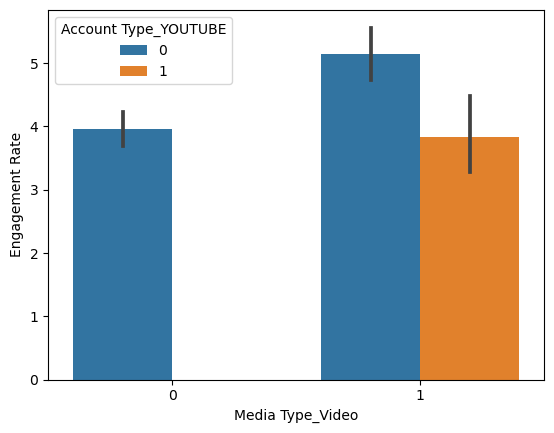

In [45]:
sns.barplot(y='Engagement Rate',x='Media Type_Video', hue='Account Type_YOUTUBE', data=one_hot_data)

<Axes: xlabel='Day Of Week_Tuesday', ylabel='Engagement Rate'>

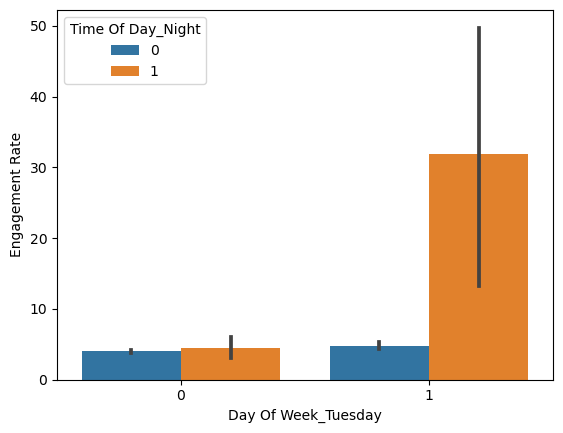

In [46]:
sns.barplot(y='Engagement Rate',x='Day Of Week_Tuesday', hue='Time Of Day_Night', data=one_hot_data)

<Axes: xlabel='Day Of Week_Tuesday', ylabel='Engagement Rate'>

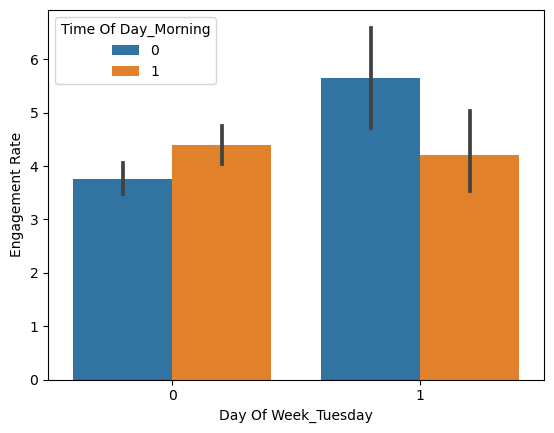

In [47]:
sns.barplot(y='Engagement Rate',x='Day Of Week_Tuesday', hue='Time Of Day_Morning', data=one_hot_data)

<Axes: xlabel='Day Of Week_Thursday', ylabel='Engagement Rate'>

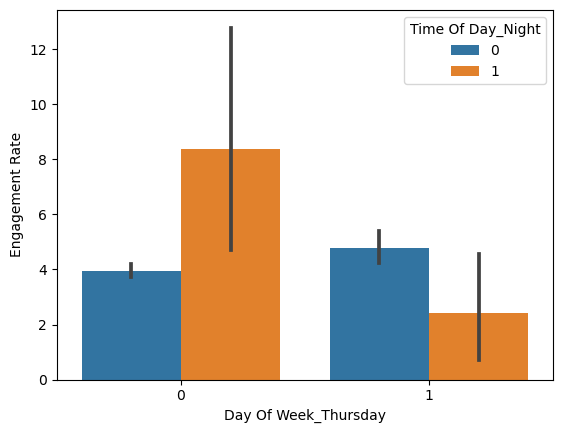

In [48]:
sns.barplot(y='Engagement Rate',x='Day Of Week_Thursday', hue='Time Of Day_Night', data=one_hot_data)

<Axes: xlabel='Day Of Week_Thursday', ylabel='Engagement Rate'>

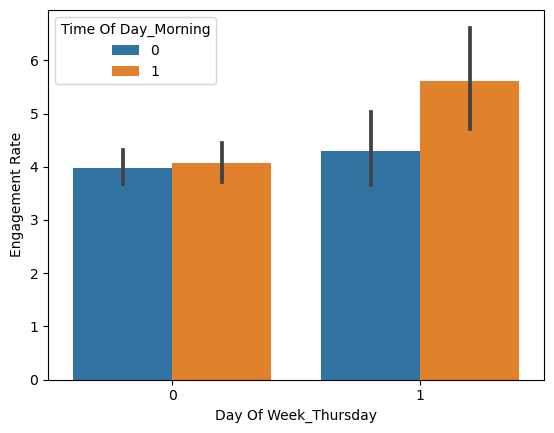

In [49]:
sns.barplot(y='Engagement Rate',x='Day Of Week_Thursday', hue='Time Of Day_Morning', data=one_hot_data)

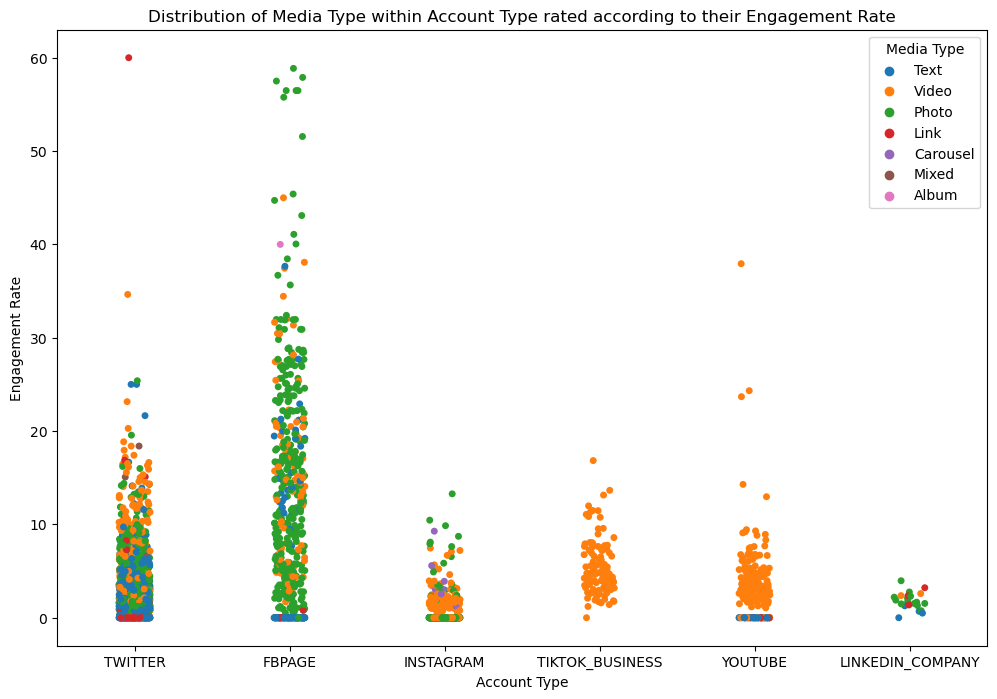

In [50]:
plt.figure(figsize=(12,8))
plt.title('Distribution of Media Type within Account Type rated according to their Engagement Rate')
sns.stripplot(y='Engagement Rate', x='Account Type', hue = 'Media Type', data=data)
plt.savefig('figs/e_media_account_dist.png')

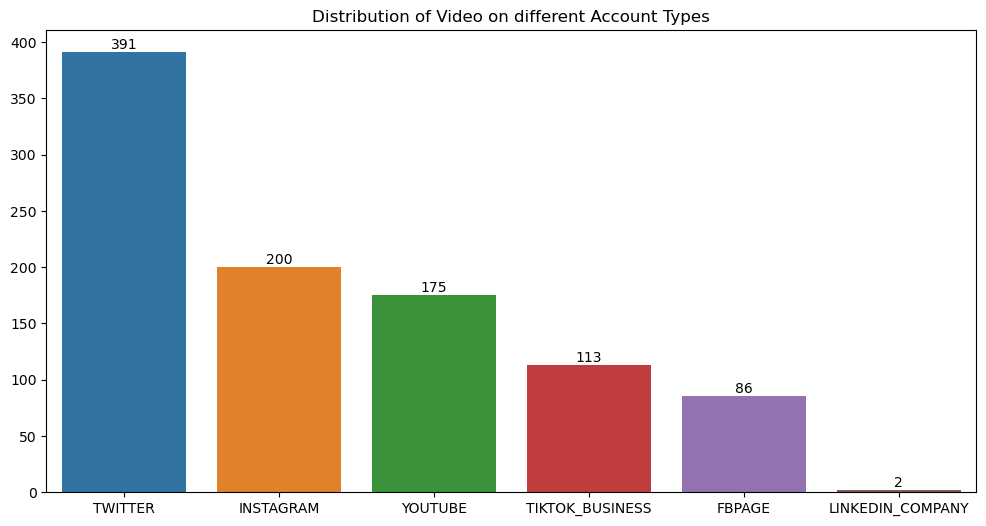

In [51]:
video_data = data[data['Media Type']=='Video']['Account Type'].value_counts()
fig7, ax7 = plt.subplots(figsize=(12,6))
plt.title("Distribution of Video on different Account Types")
ax_x = sns.barplot(x=video_data.index, y=video_data.values, ax=ax7)
for i in ax_x.containers:
    ax_x.bar_label(i,)
plt.savefig("figs/e_video_dist_account.png")

In [52]:
data[data['Media Type']=='Video'].groupby('Account Type').mean(numeric_only=True)

,Total Impressions,Total Engagements,Engagement Rate
Account Type,,,
FBPAGE,39510.313953,6530.081395,15.059735
INSTAGRAM,10365.070000,193.720000,1.141756
LINKEDIN_COMPANY,1457.000000,35.500000,2.479645
TIKTOK_BUSINESS,3045.654867,166.946903,5.316753
TWITTER,11607.253197,587.867008,4.965940
YOUTUBE,1362.302857,59.017143,3.832879


In [53]:
data[data['Account Type']=='FBPAGE'].groupby('Media Type').mean(numeric_only=True)

,Total Impressions,Total Engagements,Engagement Rate
Media Type,,,
Album,5.000000,2.000000,10.000000
Link,458.285714,3.714286,0.057891
Photo,28676.218023,5255.543605,13.396573
Text,9051.872180,1526.082707,3.927818
Video,39510.313953,6530.081395,15.059735


In [54]:
data[data['Campaign Name']=='Community Engagement '].groupby('Account Type').mean(numeric_only=True)

,Total Impressions,Total Engagements,Engagement Rate
Account Type,,,
FBPAGE,29475.847176,5420.431894,14.505180
INSTAGRAM,9684.308176,332.088050,1.208653
LINKEDIN_COMPANY,1726.444444,33.166667,1.860454
TIKTOK_BUSINESS,802.076923,46.923077,6.422724
TWITTER,14815.926585,398.155729,3.468913
YOUTUBE,1461.904762,60.285714,7.455909


In [55]:
data[data['Campaign Name']=='Community Engagement '].groupby('Media Type').mean(numeric_only=True)

,Total Impressions,Total Engagements,Engagement Rate
Media Type,,,
Carousel,18832.875000,802.250000,4.103980
Link,6645.840000,39.480000,0.686102
Mixed,7603.000000,617.000000,12.463061
Photo,20041.868453,1800.226553,5.812268
Text,9392.492891,634.180095,4.113313
Video,14638.229651,1233.517442,6.498993


In [56]:
data[data['Account']=='DOTA2']['Media Type'].value_counts()

Text     343
Photo    331
Video    118
Link       9
Mixed      2
Name: Media Type, dtype: int64

In [57]:
data[data['Account']=='DOTA2'].groupby('Media Type').mean(numeric_only=True)

,Total Impressions,Total Engagements,Engagement Rate
Media Type,,,
Link,980.777778,57.666667,5.613076
Mixed,4464.000000,706.500000,16.732484
Photo,3236.169184,207.283988,4.785465
Text,1149.279883,47.825073,3.007063
Video,3188.101695,313.923729,6.374036


In [58]:
data[data['Account Type']=='INSTAGRAM'].groupby('Media Type').mean(numeric_only=True)

,Total Impressions,Total Engagements,Engagement Rate
Media Type,,,
Carousel,17854.333333,726.777778,3.784294
Link,0.000000,0.000000,0.000000
Photo,4753.035461,137.595745,0.459752
Text,0.000000,0.000000,0.000000
Video,10365.070000,193.720000,1.141756
